In [39]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
class ReLU:
    def __init__(self):
        self.output = None
        self.input = None
    
    def forward(self, input):
        self.input = input
        self.output = np.where(self.input > 0, self.input, 0)
        return self.output
    
    def backward(self, dout):
        relu_grad = self.input > 0
        return dout*relu_grad
        # return np.where(dout > 0, 1, 0)
    
    def __call__(self, X):
        return self.forward(X)

class CE:
    def __init__(self):
        self.y_pred = None
        self.y_true = None

    def forward(self, x, y):
        batch_size = x.shape[0]
        max_values = np.max(x, axis=1, keepdims=True)
        x_shifted = x - max_values
        exp_x = np.exp(x_shifted)
        self.y_pred = exp_x / np.sum(exp_x, axis=1, keepdims=True)  # softmax
        self.y_true = y  # one-hot вектор
        return -np.sum(self.y_true * np.log(self.y_pred + 1e-9)) / batch_size  # 1e-9 для численной стабильности
    
    def backward(self, out, y):
        batch_size = out.shape[0]
        return (self.y_pred - y) / batch_size  # softmax(x) - y

    def __call__(self, out, y):
        return self.forward(out, y)

class Softmax:
    def __init__(self):
        self.output = None
        
    def forward(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True)
        
    def __call__(self, x):
        return self.forward(x)


In [41]:
class Layer:
    def __init__(self, input_size, output_size, num, random_weights):
        self.num = num
        if random_weights:
            self.weights = np.random.uniform(-1 / np.sqrt(input_size), 1 / np.sqrt(input_size), (input_size, output_size))
            self.bias = np.random.randn(output_size)
            
        else:
            df_wghts = pd.read_csv(f'weights/weights_{self.num}.csv')
            self.weights = df_wghts.iloc[:, :-1].to_numpy()
            self.bias = df_wghts.iloc[:output_size, -1].to_numpy()
            # print(self.weights.shape, self.bias.shape)
        
    def forward(self, x):
        self.input = x
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    def backward(self, error, lr):
        d_output = np.dot(error, self.weights.T)
        self.weights -= lr * np.dot(self.input.T, error)
        self.bias -= lr * np.sum(error, axis=0)
        return d_output
    
    def weights_save_layer(self):
        df_bias = pd.DataFrame(self.bias)
        df_weights = pd.DataFrame(self.weights)
        wght = pd.concat([df_weights, df_bias], axis=1)
        wght.to_csv(f'weights/weights_{self.num}.csv', index=False)

In [42]:
class NetNum():
    def __init__(self, input_size, input_size_2, input_size_3, output_size, lr, random_weights=False):
        self.lr = lr
        self.layer_1 = Layer(input_size=input_size, output_size=input_size_2, num=1, random_weights=random_weights)
        self.layer_1_act = ReLU()
        self.layer_2 = Layer(input_size=input_size_2, output_size=input_size_3, num=2, random_weights=random_weights)
        self.layer_2_act = ReLU()
        self.layer_3 = Layer(input_size=input_size_3, output_size=output_size, num=3, random_weights=random_weights)
        self.ce = CE()

    def forward_prop(self, x):
        x = self.layer_1.forward(x)
        layer_1_acc = self.layer_1_act(x)
        x = self.layer_2.forward(layer_1_acc)
        layer_2_acc = self.layer_2_act(x)
        x = self.layer_3.forward(layer_2_acc)
        return x

    def backward_prop(self, out, y):
        # Не самое лучшее решение, но я не хочу заморачиваться с градиентами
        # Но на будущее - лучше CE вынести в метод обучения
        dout = self.ce.backward(out, y)
        x = self.layer_3.backward(dout, self.lr)
        x = self.layer_2_act.backward(x)
        x = self.layer_2.backward(x, self.lr)
        x = self.layer_1_act.backward(x)
        x = self.layer_1.backward(x, self.lr)

    def train(self, X, y, epochs, batch_size=32, split=0.8, shuffle=True, seed=42):
        train_loss_history = []
        val_loss_history = []
        
        # Разделяем данные на обучающую и валидационную выборки
        split_idx = int(len(X) * split)
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]
        
        pbar = tqdm(range(epochs))

        # Рандомизируем данные
        np.random.seed(seed)
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for epoch in pbar:
            epoch_loss = 0
            # Перемешиваем данные
            if shuffle:
                indices = np.random.permutation(len(X_train))
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]
            
            # Разбиваем на батчи
            num_batches = 0
            for i in range(0, len(X_train), batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Прямое распространение
                out = self.forward_prop(X_batch)
                
                # Вычисляем функцию потерь
                batch_loss = self.ce(out, y_batch)
                epoch_loss += batch_loss
                
                # Обратное распространение
                self.backward_prop(out, y_batch)
                num_batches += 1
            
            # Средняя потеря за эпоху
            avg_epoch_loss = epoch_loss / num_batches
            train_loss_history.append(avg_epoch_loss)
            
            # Проверяем на валидационной выборке
            val_loss = 0
            num_val_batches = 0
            
            for i in range(0, len(X_val), batch_size):
                X_val_batch = X_val[i:i+batch_size]
                y_val_batch = y_val[i:i+batch_size]
                
                # Только прямое распространение для валидации
                val_out = self.forward_prop(X_val_batch)
                val_batch_loss = self.ce(val_out, y_val_batch)
                val_loss += val_batch_loss
                num_val_batches += 1
            
            avg_val_loss = val_loss / num_val_batches if num_val_batches > 0 else 0
            val_loss_history.append(avg_val_loss)
                
            # Обновляем описание прогресс-бара с информацией о валидации и тренировке
            pbar.set_description(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        return train_loss_history, val_loss_history
    
    def predict(self, x):
        output = self.forward_prop(x)
        return output
    
    def weights_save(self):
        self.layer_1.weights_save_layer()
        self.layer_2.weights_save_layer()
        self.layer_3.weights_save_layer()
    
    def accuracy(self, X, y):
        correct = 0
        total = len(X)
        
        for i in range(total):
            pred = self.predict(X[i].reshape(1, -1))
            pred_class = np.argmax(pred)
            true_class = np.argmax(y[i])
            if pred_class == true_class:
                correct += 1
                
        accuracy = correct / total
        print(f"Accuracy: {accuracy:.4f}")
        return accuracy

In [43]:
df = pd.read_csv('mnist_train.csv')

onehot = pd.get_dummies(df['label']).values

X = df.drop('label', axis=1).values / 255.0

indices_by_class = [df.index[df['label'] == i] for i in range(10)]
valid_indices = np.concatenate(indices_by_class)
np.random.shuffle(valid_indices)

X_train = X[valid_indices][:-100]
y_train = onehot[valid_indices][:-100]

X_test = X[valid_indices][-100:]
y_test = onehot[valid_indices][-100:]

Epoch 2000/2000 | Train Loss: 0.000652 | Val Loss: 0.117130: 100%|██████████| 2000/2000 [1:24:24<00:00,  2.53s/it]


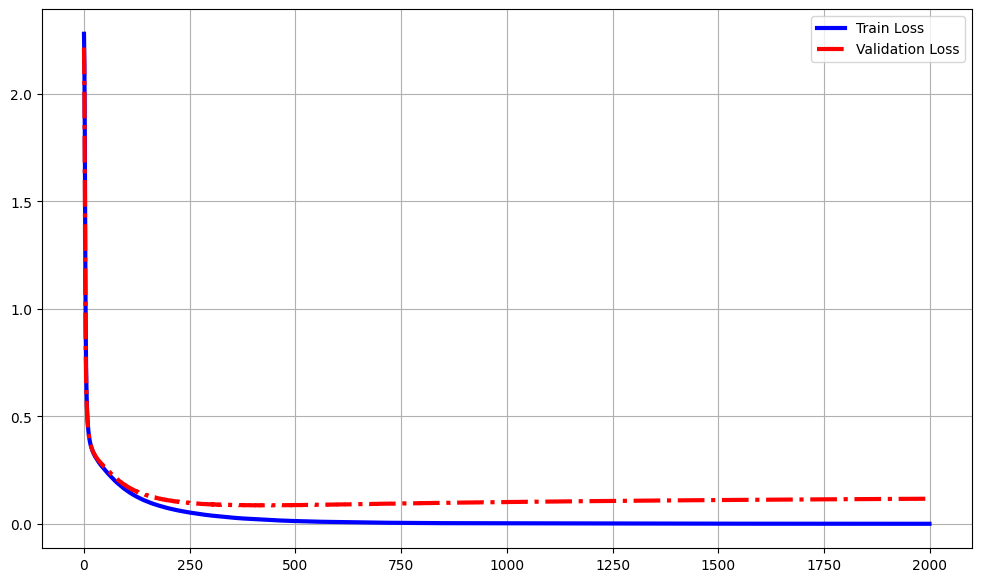

In [ ]:
NN = NetNum(input_size=784, input_size_2=256, input_size_3=64, output_size=10, lr=0.005, random_weights=True) # random_weights=False(веса из папки weights) по двефолту
train_loss, val_loss = NN.train(X_train, y_train, epochs=2000, batch_size=128)
plt.figure(figsize=(12, 7))
plt.plot(train_loss, '-b',label="Train Loss", lw=3, ms=0)
plt.plot(val_loss, '-.r', label="Validation Loss", lw=3, ms=0)
plt.legend()
plt.grid(True)

In [49]:
acc = NN.accuracy(X_test, y_test)

Accuracy: 0.9500


In [50]:
train_loss_min = 9999
val_loss_min = 9999
acc_max = 0
if train_loss[-1] <= train_loss_min and val_loss[-1] <= val_loss_min and acc >= acc_max:
    train_loss_min = train_loss[-1]
    val_loss_min = val_loss[-1]
    acc_max = acc
    NN.weights_save()
    print('Лучшие веса сохранены в папку weights')

Лучшие веса сохранены в папку weights
